In [2]:
%pip install scikit-learn==1.4.1.post1 seaborn==0.13.2 fasteda==1.0.1

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for fasteda: filename=fasteda-1.0.1-py3-none-any.whl size=4739 sha256=3d12e49fa76cb7b9a08fb8d74d7f6132b8ea941b9b9abc34b96e46f16b99825b
  Stored in directory: c:\users\c4297\appdata\local\pip\cache\wheels\93\57\7e\fdc4b9923cf3f1f46de4e2ea7a5a4acb335357f919920ffb7c
Successfully built fasteda
Note: you may need to restart the kernel to use updated packages.


In [3]:
import random
random.seed(2024)

import missingno as msno
import numpy as np
from scipy.stats import shapiro
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import load_diabetes, load_iris
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from fasteda import fast_eda

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

<hr style="border:2px solid gray">


## Load the diabetes data set


In [4]:
# Load the data from `sklearn` as two pandas.DataFrame
diabetes_X, diabetes_y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

# Concatenate the two pandas.DataFrames into one
diabetes = pd.concat([diabetes_X, pd.Series(diabetes_y)], axis=1).rename({0: 'target'},axis=1)

# Load the data set from `sklearn` using another method in order to print 
# the data set description of the data
diabetes_default = load_diabetes()

# Print the data set description:
print(diabetes_default['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

Also take a look at 5 randomly selected rows in the data set.


In [5]:
diabetes.sample(5)

age  sex   bmi    bp     s1     s2    s3   s4      s5    s6  target
131  22.0  1.0  19.9  75.0  175.0  108.6  54.0  3.0  4.1271  72.0   158.0
3    24.0  1.0  25.3  84.0  198.0  131.4  40.0  5.0  4.8903  89.0   206.0
424  49.0  2.0  27.4  89.0  177.0  113.0  37.0  5.0  4.9053  97.0   111.0
384  58.0  2.0  23.6  96.0  257.0  171.0  59.0  4.0  4.9053  82.0    69.0
133  37.0  2.0  21.4  83.0  128.0   69.6  49.0  3.0  3.8501  84.0    83.0

# Add some missing values


The original data set does not contain any missing values. To verify this, run the following code, which outputs `True` if there are missing values and `False` otherwise.


In [6]:
diabetes.isna().max(axis=0).max()

False

In [7]:
int(np.round(len(diabetes.index.tolist())/10))

44

In [8]:
# Set the random seed for reproducibility
random.seed(2024)

# Select 3 columns at random
missing_cols = random.sample(range(len(diabetes.columns) - 1), 3)

# Select 10% of the rows at random
missing_rows = random.sample(diabetes.index.tolist(), int(np.round(len(diabetes.index.tolist())/10)))

# Set the 3 selected columns to missing values for the 10% of selected rows
diabetes.iloc[missing_rows, missing_cols] = np.nan

To see which columns were randomly selected, run the following cell.


In [9]:
print(sorted(diabetes.columns[missing_cols]))

['bmi', 's1', 's4']


In [10]:
# Initialize the one-hot encoder
enc1 = OneHotEncoder(handle_unknown='ignore', drop=None)

# One-hot encode 'sex'; the output is a numpy array
encoded_sex = enc1.fit_transform(diabetes[['sex']]).toarray()

# Convert numpy array to pandas DataFrame with columns names based on original category labels
encoded_sex = pd.DataFrame(encoded_sex, columns=['sex' + str(int(x)) for x in enc1.categories_[0]])

# Horizontally concatenate the original 'diabetes' data set with the two one-hot columns
diabetes = pd.concat([diabetes, encoded_sex], axis=1)

# Sample 10 rows. Print only the 'sex', 'sex1', and 'sex2' columns for simplicity
diabetes[['sex', 'sex1', 'sex2']].sample(10)

sex  sex1  sex2
87   1.0   1.0   0.0
389  2.0   0.0   1.0
404  1.0   1.0   0.0
248  1.0   1.0   0.0
6    2.0   0.0   1.0
14   1.0   1.0   0.0
388  2.0   0.0   1.0
144  2.0   0.0   1.0
165  1.0   1.0   0.0
373  1.0   1.0   0.0

In [11]:
# Dropping 'sex' and 'sex2'
diabetes = diabetes.drop(['sex', 'sex2'], axis=1)
# Reorder columns to have 'sex1' where 'sex' used to be
diabetes = diabetes.loc[:, ['age', 'sex1','bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']]
# Print a sample of 5 rows
diabetes.sample(5)

age  sex1   bmi     bp     s1     s2    s3   s4      s5     s6  target
113  54.0   0.0  27.7  113.0  200.0  128.4  37.0  5.0  5.1533  113.0   297.0
110  60.0   0.0  23.4   88.0  153.0   89.8  58.0  3.0  3.2581   95.0   104.0
19   41.0   1.0  24.7   83.0  187.0  108.2  60.0  3.0  4.5433   78.0   168.0
225  57.0   0.0  29.4  109.0  160.0   87.6  31.0  5.0  5.3327   92.0   208.0
180  38.0   0.0  26.8  105.0  181.0  119.2  37.0  5.0  4.8203   91.0   107.0

### Make a train-test split



In [12]:
# Make a train-test split
X_train, X_test, y_train, y_test = train_test_split(diabetes.iloc[:, :-1], diabetes.iloc[:, [-1]], test_size=0.33, random_state=2024)

## Perform EDA



### A look at the beginning and end of the data set


In [13]:
diabetes.head()

age  sex1   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0   0.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0   1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0   0.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0
3  24.0   1.0  25.3   84.0  198.0  131.4  40.0  5.0  4.8903  89.0   206.0
4  50.0   1.0  23.0  101.0  192.0  125.4  52.0  4.0  4.2905  80.0   135.0

---


In [14]:

diabetes.tail()

age  sex1   bmi      bp     s1     s2    s3    s4      s5     s6  target
437  60.0   0.0  28.2  112.00  185.0  113.8  42.0  4.00  4.9836   93.0   178.0
438  47.0   0.0  24.9   75.00  225.0  166.0  42.0  5.00  4.4427  102.0   104.0
439  60.0   0.0  24.9   99.67  162.0  106.6  43.0  3.77  4.1271   95.0   132.0
440  36.0   1.0  30.0   95.00  201.0  125.2  42.0  4.79  5.1299   85.0   220.0
441  36.0   1.0  19.6   71.00  250.0  133.2  97.0  3.00  4.5951   92.0    57.0

---


### Describe the DataFrame



In [15]:
diabetes.describe()

age        sex1         bmi          bp          s1          s2  \
count  442.000000  442.000000  398.000000  442.000000  398.000000  442.000000   
mean    48.518100    0.531674   26.425879   94.647014  189.266332  115.439140   
std     13.109028    0.499561    4.445336   13.831283   34.391866   30.413081   
min     19.000000    0.000000   18.000000   62.000000   97.000000   41.600000   
25%     38.250000    0.000000   23.125000   84.000000  165.000000   96.050000   
50%     50.000000    1.000000   25.800000   93.000000  186.000000  113.000000   
75%     59.000000    1.000000   29.500000  105.000000  209.000000  134.500000   
max     79.000000    1.000000   42.200000  133.000000  301.000000  242.400000   

               s3          s4          s5          s6      target  
count  442.000000  398.000000  442.000000  442.000000  442.000000  
mean    49.788462    4.075075    4.641411   91.260181  152.133484  
std     12.934202    1.282526    0.522391   11.496335   77.093005  
min     22.000000    2.000000    3.258100   58.000000   25.000000  
25%     40.250000    3.000000    4.276700   83.250000   87.000000  
50%     48.000000    4.000000    4.620050   91.000000  140.500000  
75%     57.750000    5.000000    4.997200   98.000000  211.500000  
max     99.000000    9.090000    6.107000  124.000000  346.000000

---


### Missing values


In [16]:
diabetes.isna().sum()

age        0
sex1       0
bmi       44
bp         0
s1        44
s2         0
s3         0
s4        44
s5         0
s6         0
target     0
dtype: int64

<AxesSubplot:>

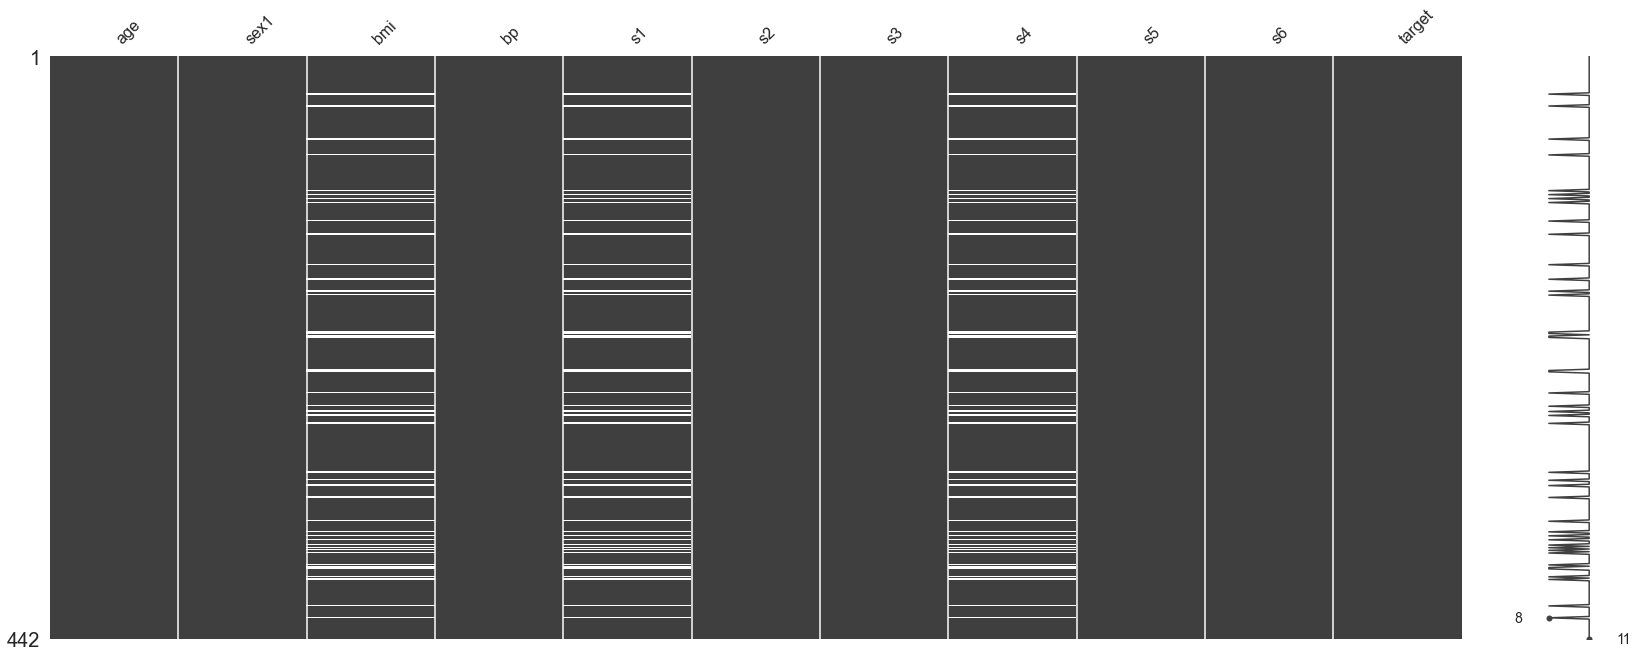

In [17]:
#using msno to check for the pattern in missing values
msno.matrix(diabetes)


---


In [18]:
diabetes.index[diabetes['bmi'].isna()][0]

29

### Checking which method is beneficial

### Drop missing observations



In [19]:
# linear regression dropping NANs

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train.loc[nonnan_train_indices], y_train.loc[nonnan_train_indices])
# Generate predictions 
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

56.026782905782134

### Fill in missing values with the mean


In [20]:
# linear regression with mean fill

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# Fit the simple imputer using the training data
imp_mean.fit(X_train)
# Actually mean fill the training data
X_train_mean_filled = imp_mean.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_mean_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

55.73138848088283

### Fill in missing values with the median



In [21]:
# linear regression with median fill

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan,strategy="median")
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

55.73430866847311

### Histograms and boxplots




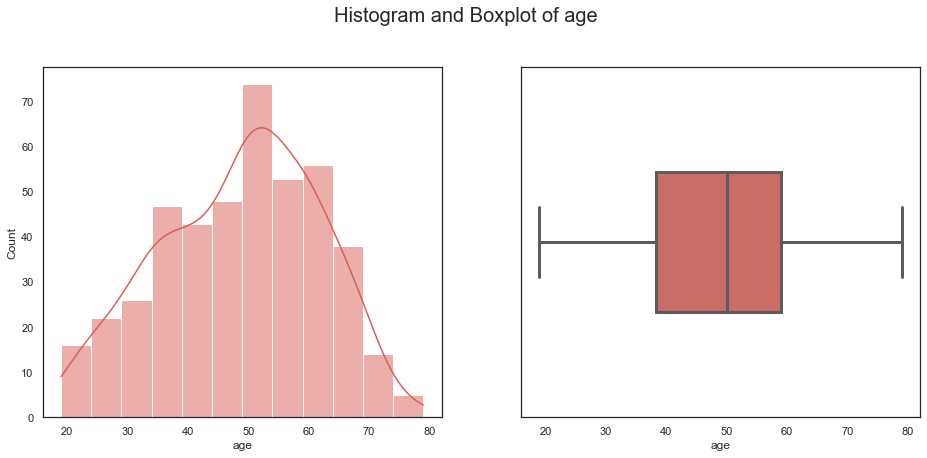

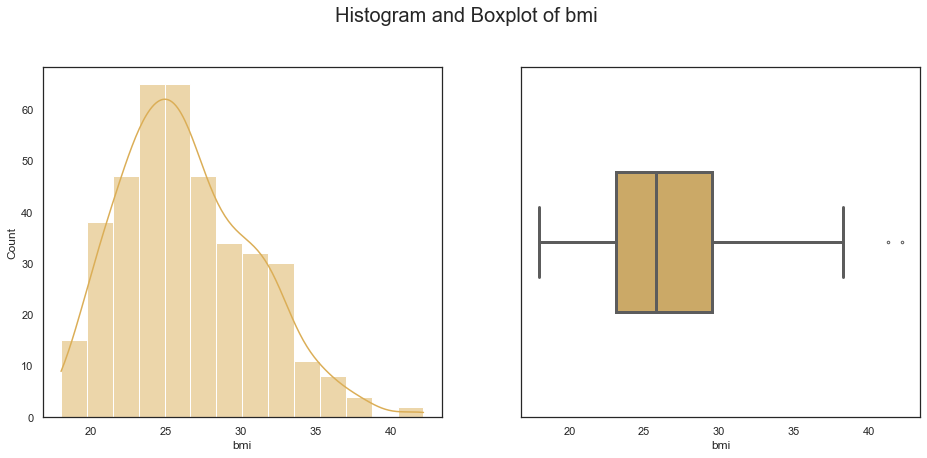

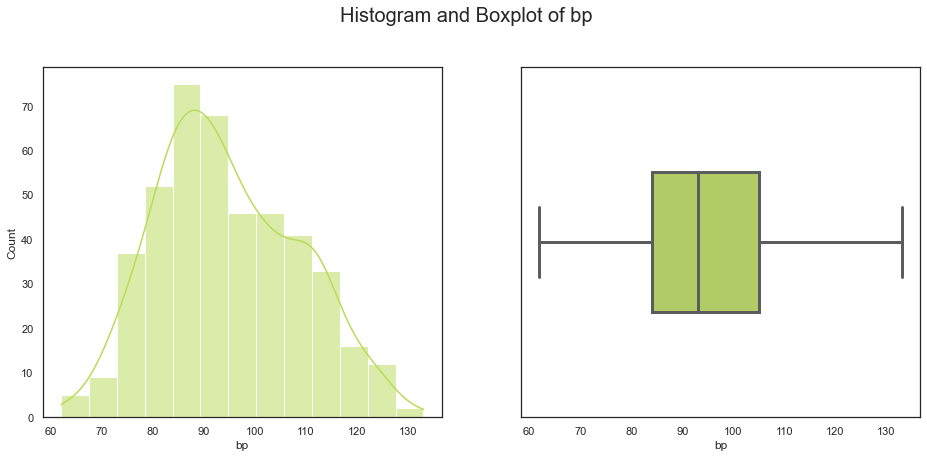

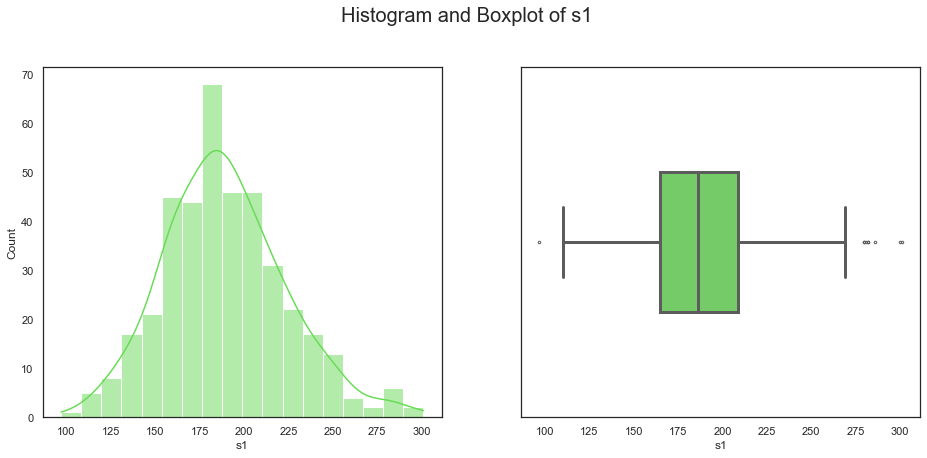

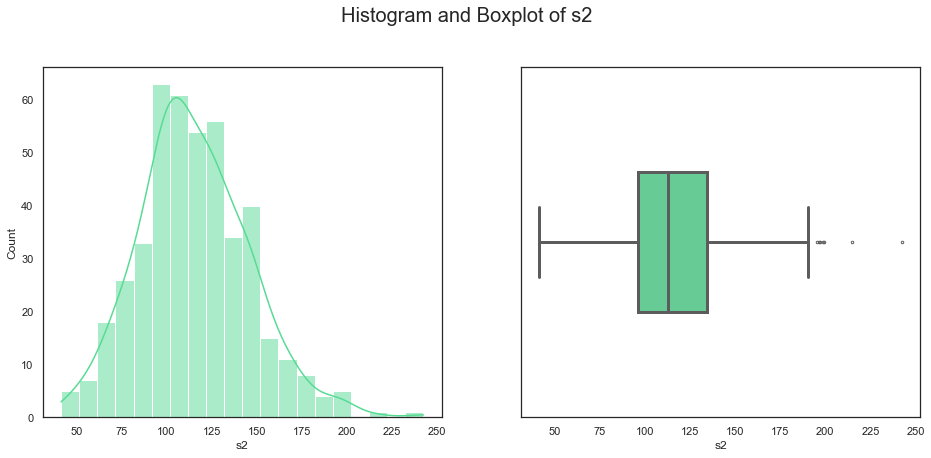

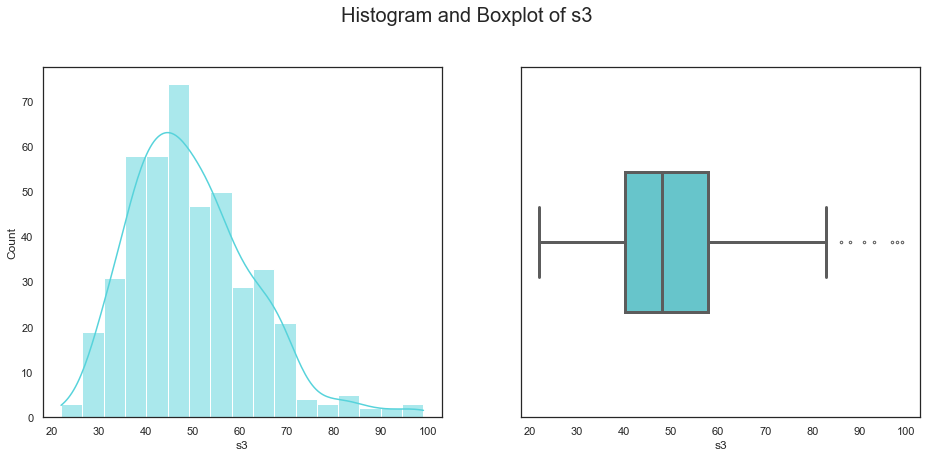

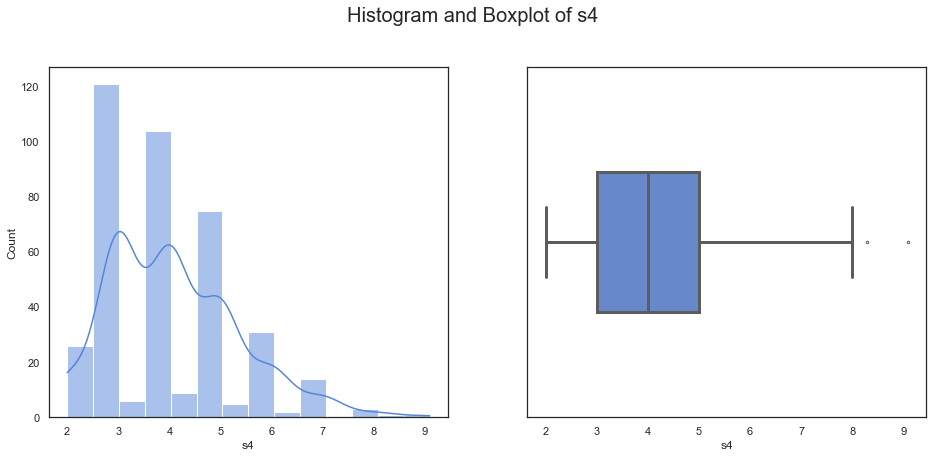

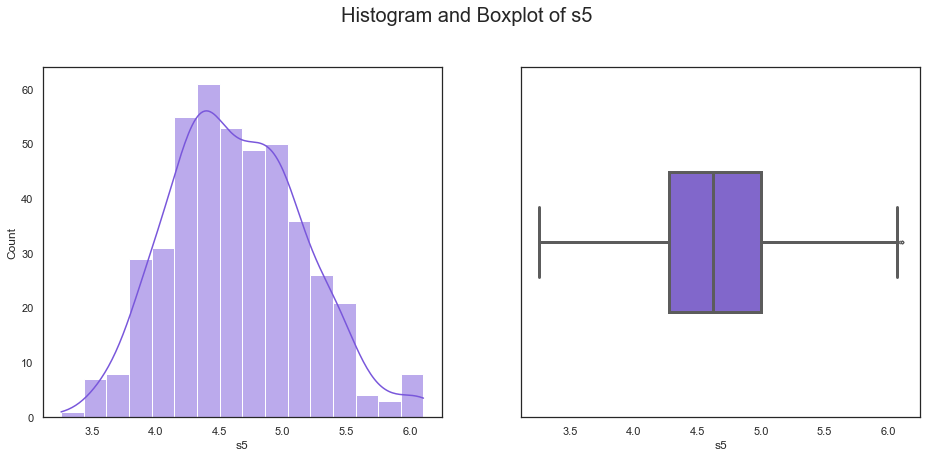

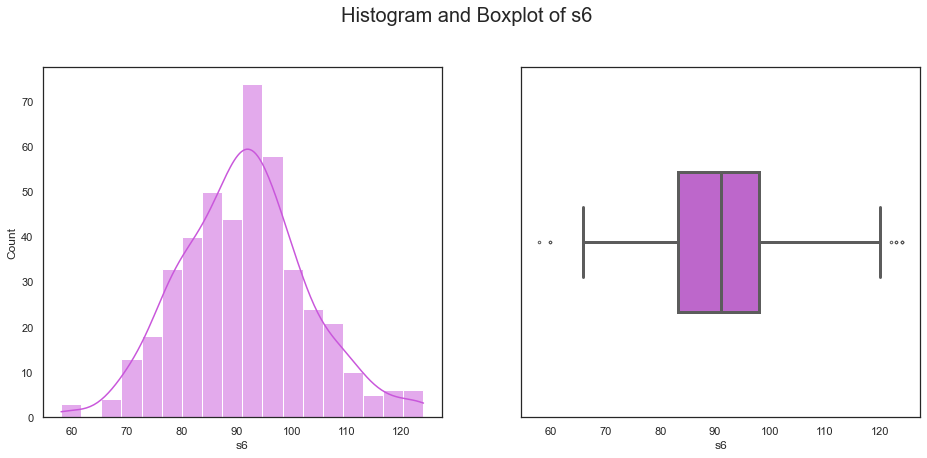

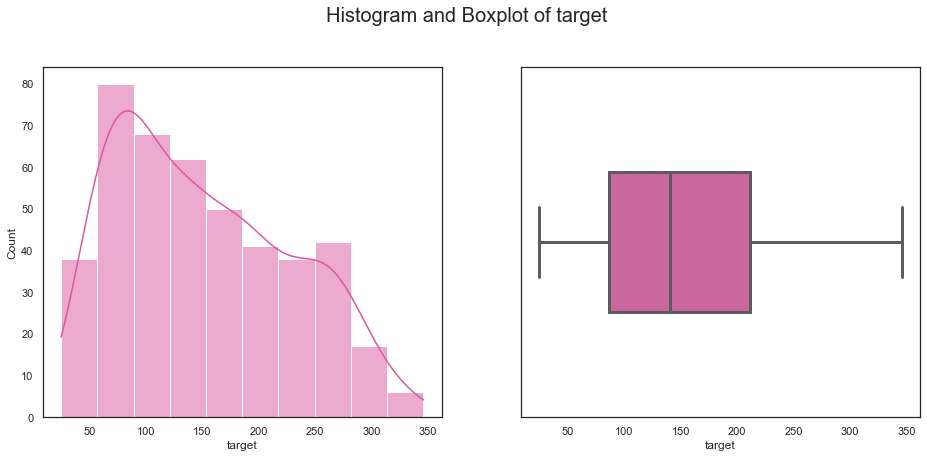

In [22]:
for idx, col in enumerate([i for i in diabetes.columns if i != 'sex1']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len([i for i in diabetes.columns if i != 'sex1']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len([i for i in diabetes.columns if i != 'sex1']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

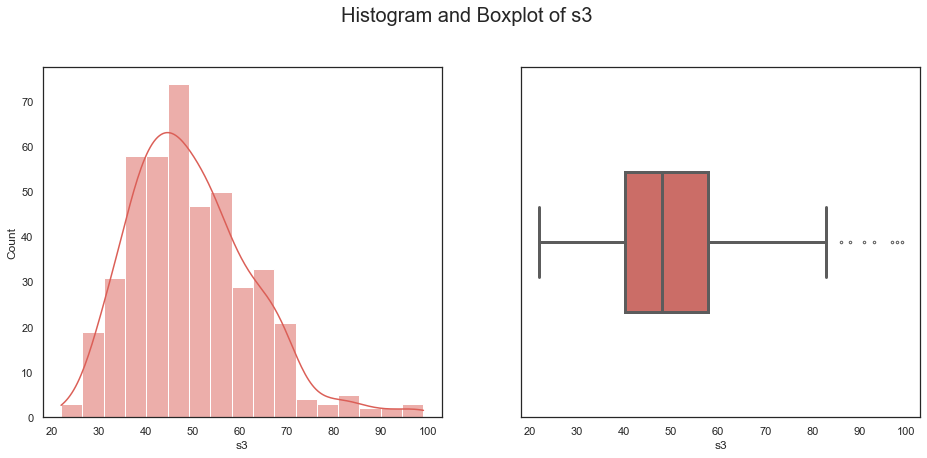

In [23]:
for idx, col in enumerate(['s3']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len(['s3']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len(['s3']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

In [24]:
# normality test on s3
stat, p = shapiro(X_train['s3'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks normally distributed (fail to reject H0)')
else:
    print('Sample does not look normally distributed (reject H0)')

Statistics=0.962, p=0.000
Sample does not look normally distributed (reject H0)


### Normality Test on S3

In [25]:
# normality test on log of s3
stat, p = shapiro(np.log(X_train['s3']))
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks normally distributed (fail to reject H0)')
else:
    print('Sample does not look normally distributed (reject H0)')

Statistics=0.996, p=0.700
Sample looks normally distributed (fail to reject H0)


In [26]:
# linear regression with median fill, and using the log of 's3'

X_train['s3'] = np.log(X_train['s3'])
X_test['s3'] = np.log(X_test['s3'])

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

55.541822812094814

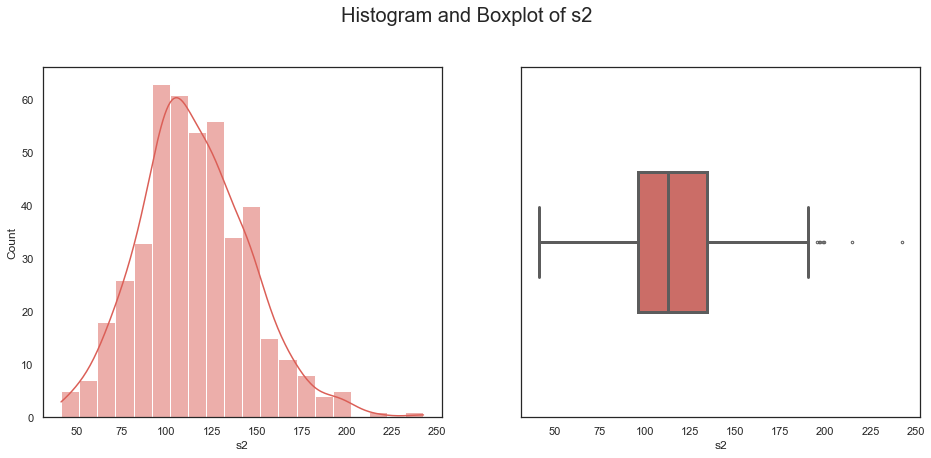

In [27]:
for idx, col in enumerate(['s2']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len(['s2']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len(['s2']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

In [28]:
# linear regression with median fill, using the log of 's3', and removal of outlier from 's2':

# Outlier removal
X_train_nonoutlier_idx = X_train.index[X_train.s2 < X_train.s2.quantile(0.999)]
X_train = X_train.loc[X_train_nonoutlier_idx]
y_train = y_train.loc[X_train_nonoutlier_idx]

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

55.36663047771339

### Correlation matrix

The following code generates a correlation matrix.


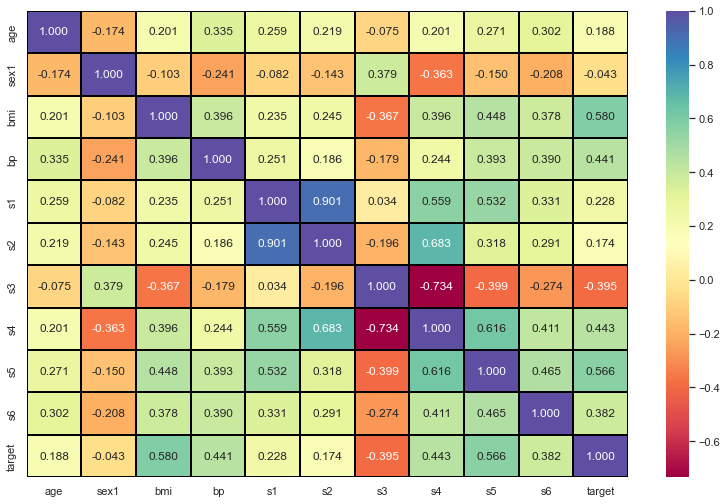

In [29]:
plt.figure(figsize = (12, 8))
sns.heatmap(diabetes.corr(), annot = True, cmap = "Spectral", linewidths = 2, linecolor = "#000000", fmt='.3f')
plt.show()

In [30]:

# Get column names that do not include 's1'
cols_no_s1 = [i for i in X_train.columns if i != 's1']

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train.loc[:, cols_no_s1])
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train.loc[:, cols_no_s1])

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices, cols_no_s1])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

55.39168020911941

### Pair plots

The following code outputs the pair plots for the `diabetes` data set.


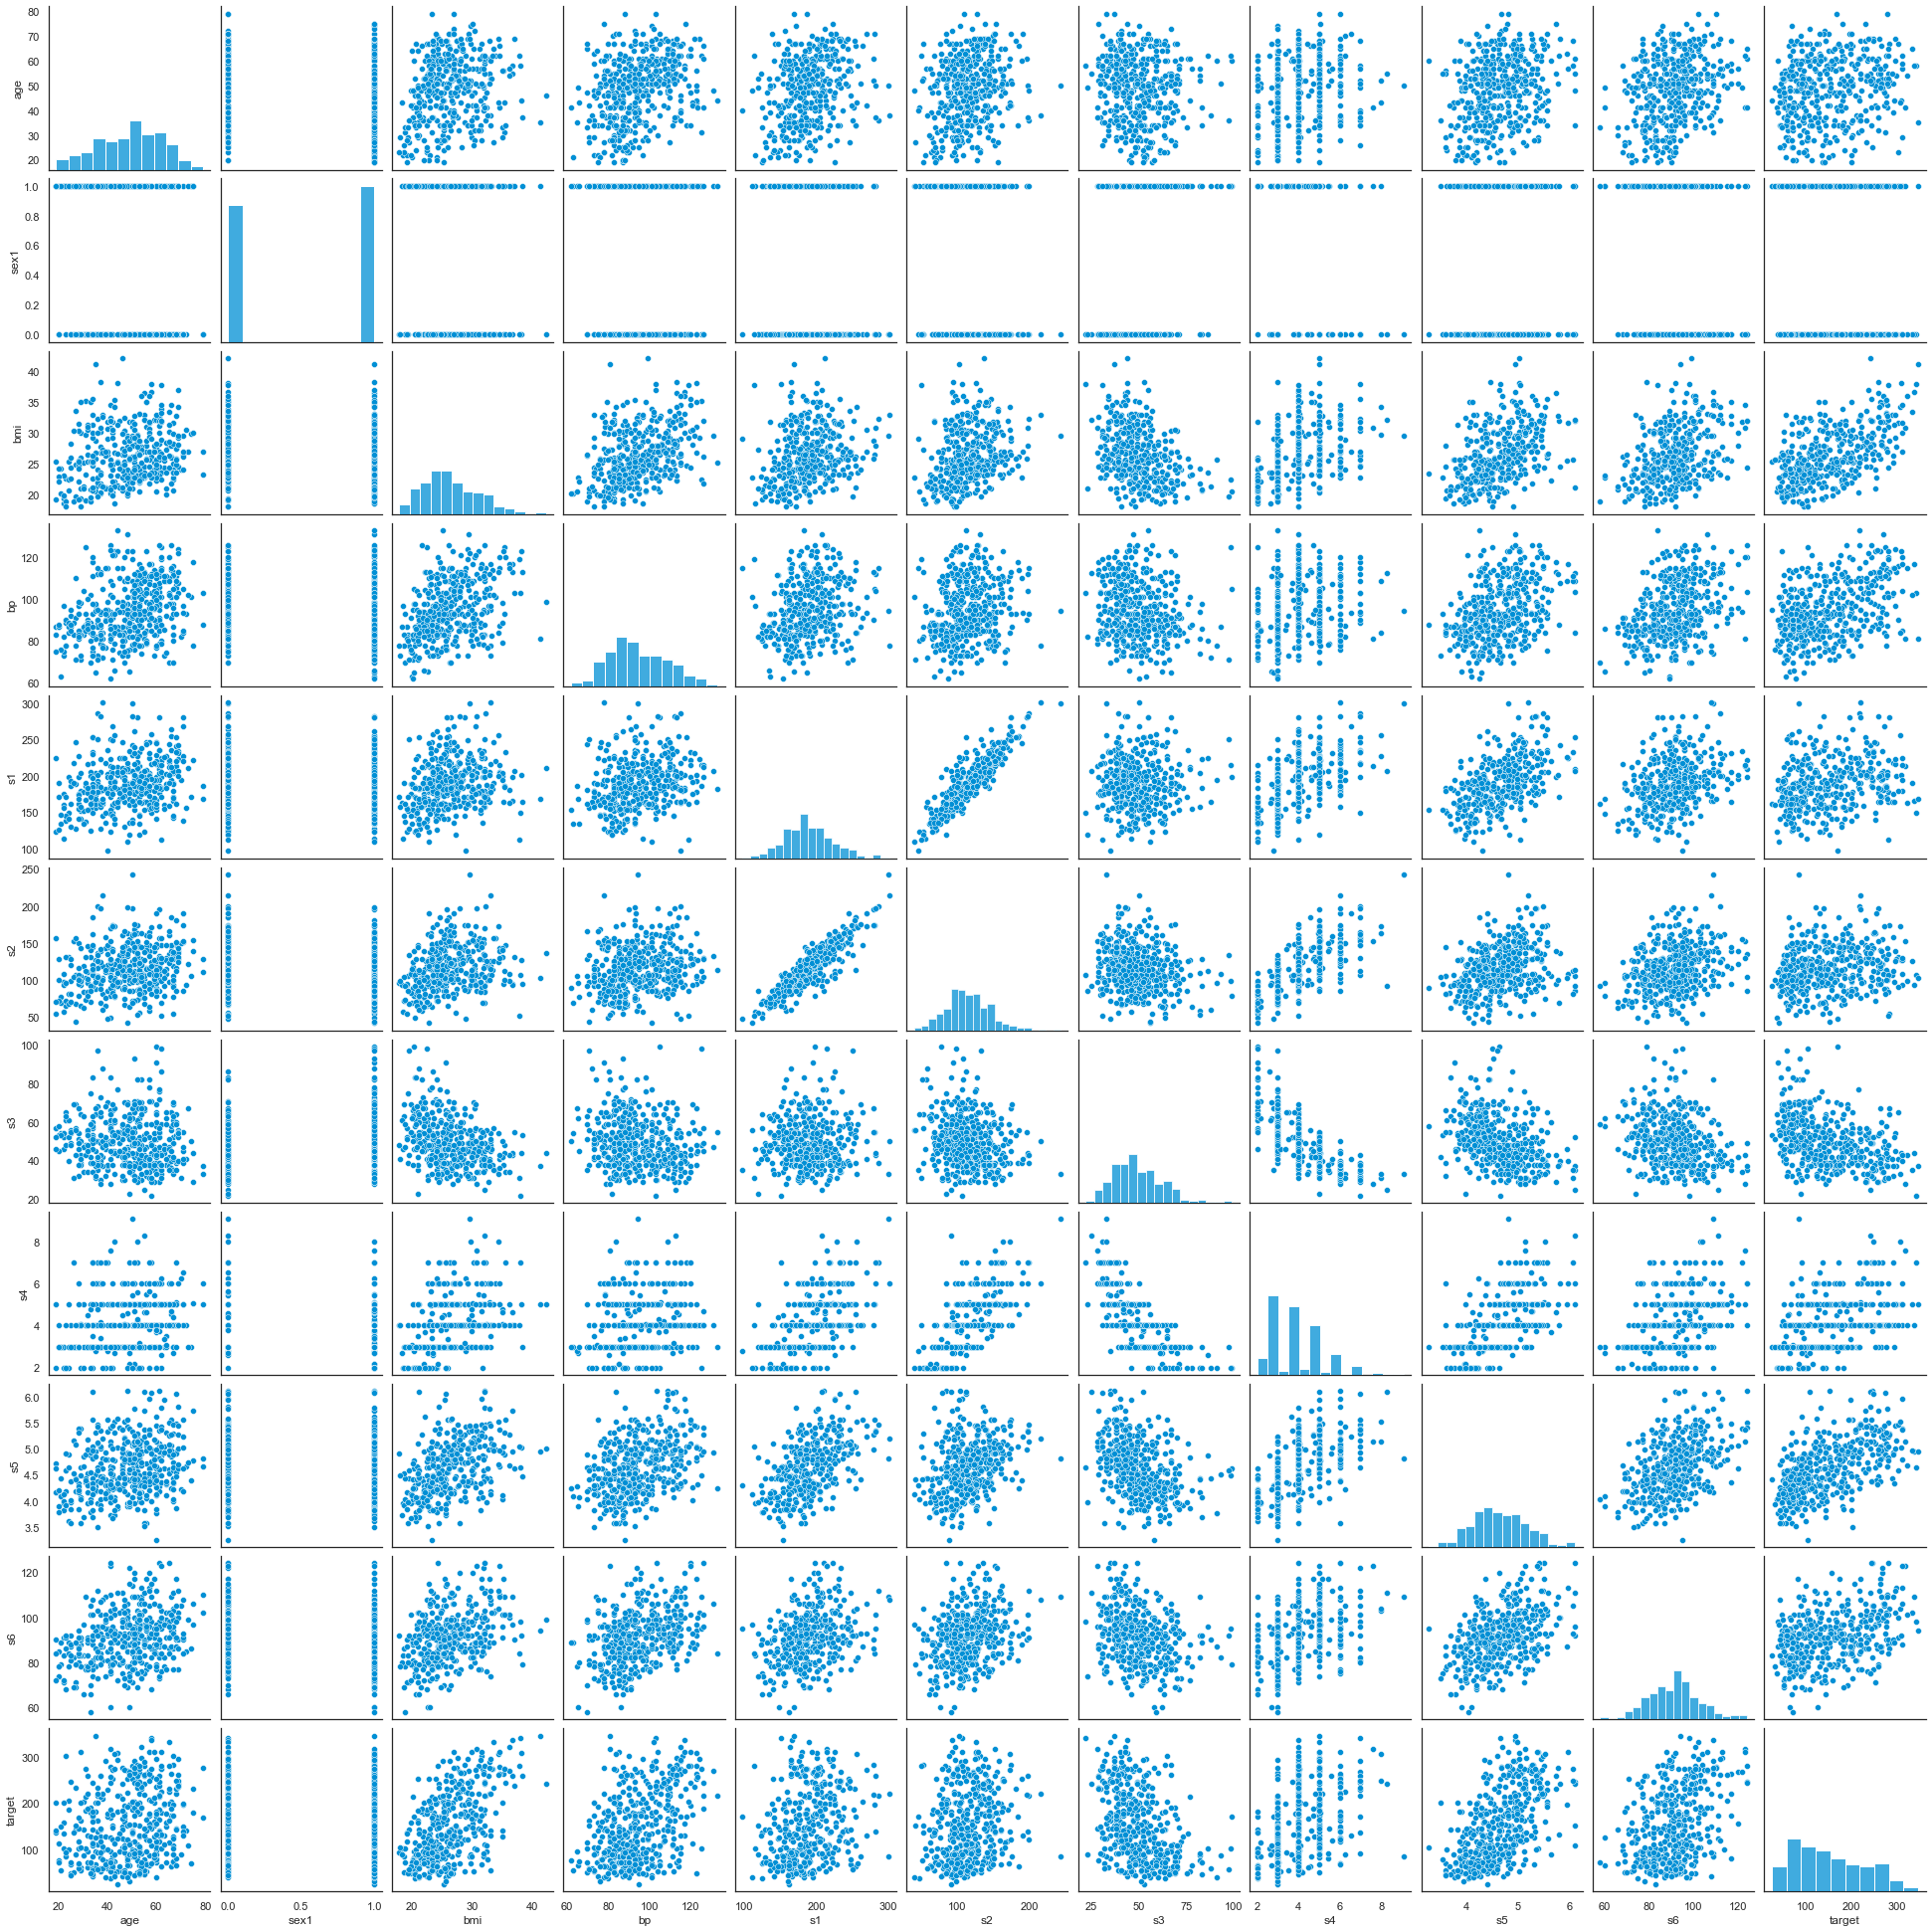

In [31]:
# This code may take a minute or two to finish running
sns.pairplot(diabetes)
plt.show()

### A simple function to perform EDA



DataFrame Head:


age  sex1   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0   0.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0   1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0   0.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0

DataFrame Tail:


age  sex1   bmi     bp     s1     s2    s3    s4      s5    s6  target
439  60.0   0.0  24.9  99.67  162.0  106.6  43.0  3.77  4.1271  95.0   132.0
440  36.0   1.0  30.0  95.00  201.0  125.2  42.0  4.79  5.1299  85.0   220.0
441  36.0   1.0  19.6  71.00  250.0  133.2  97.0  3.00  4.5951  92.0    57.0

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
MSNO Matrix:



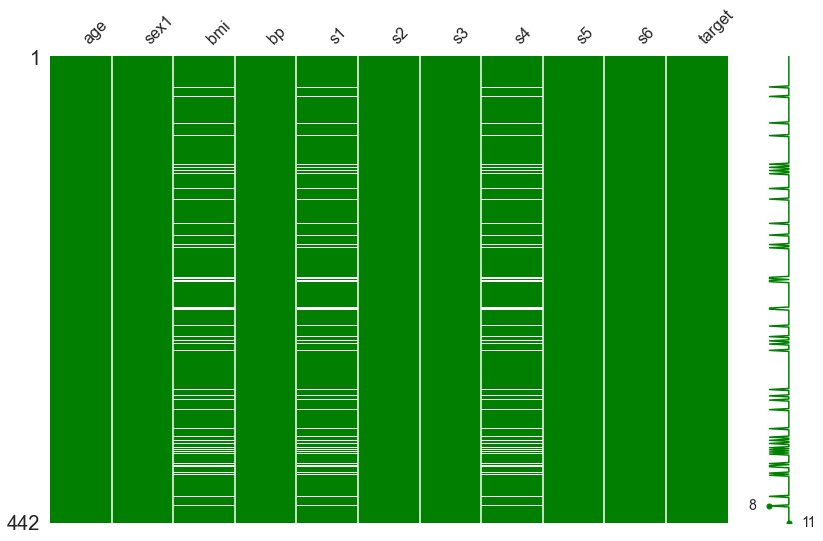

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(442, 11)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex1    442 non-null    float64
 2   bmi     398 non-null    float64
 3   bp      442 non-null    float64
 4   s1      398 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      398 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



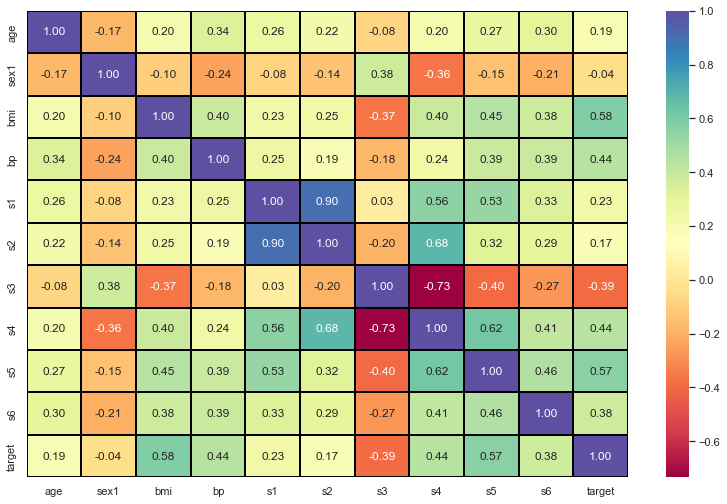

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



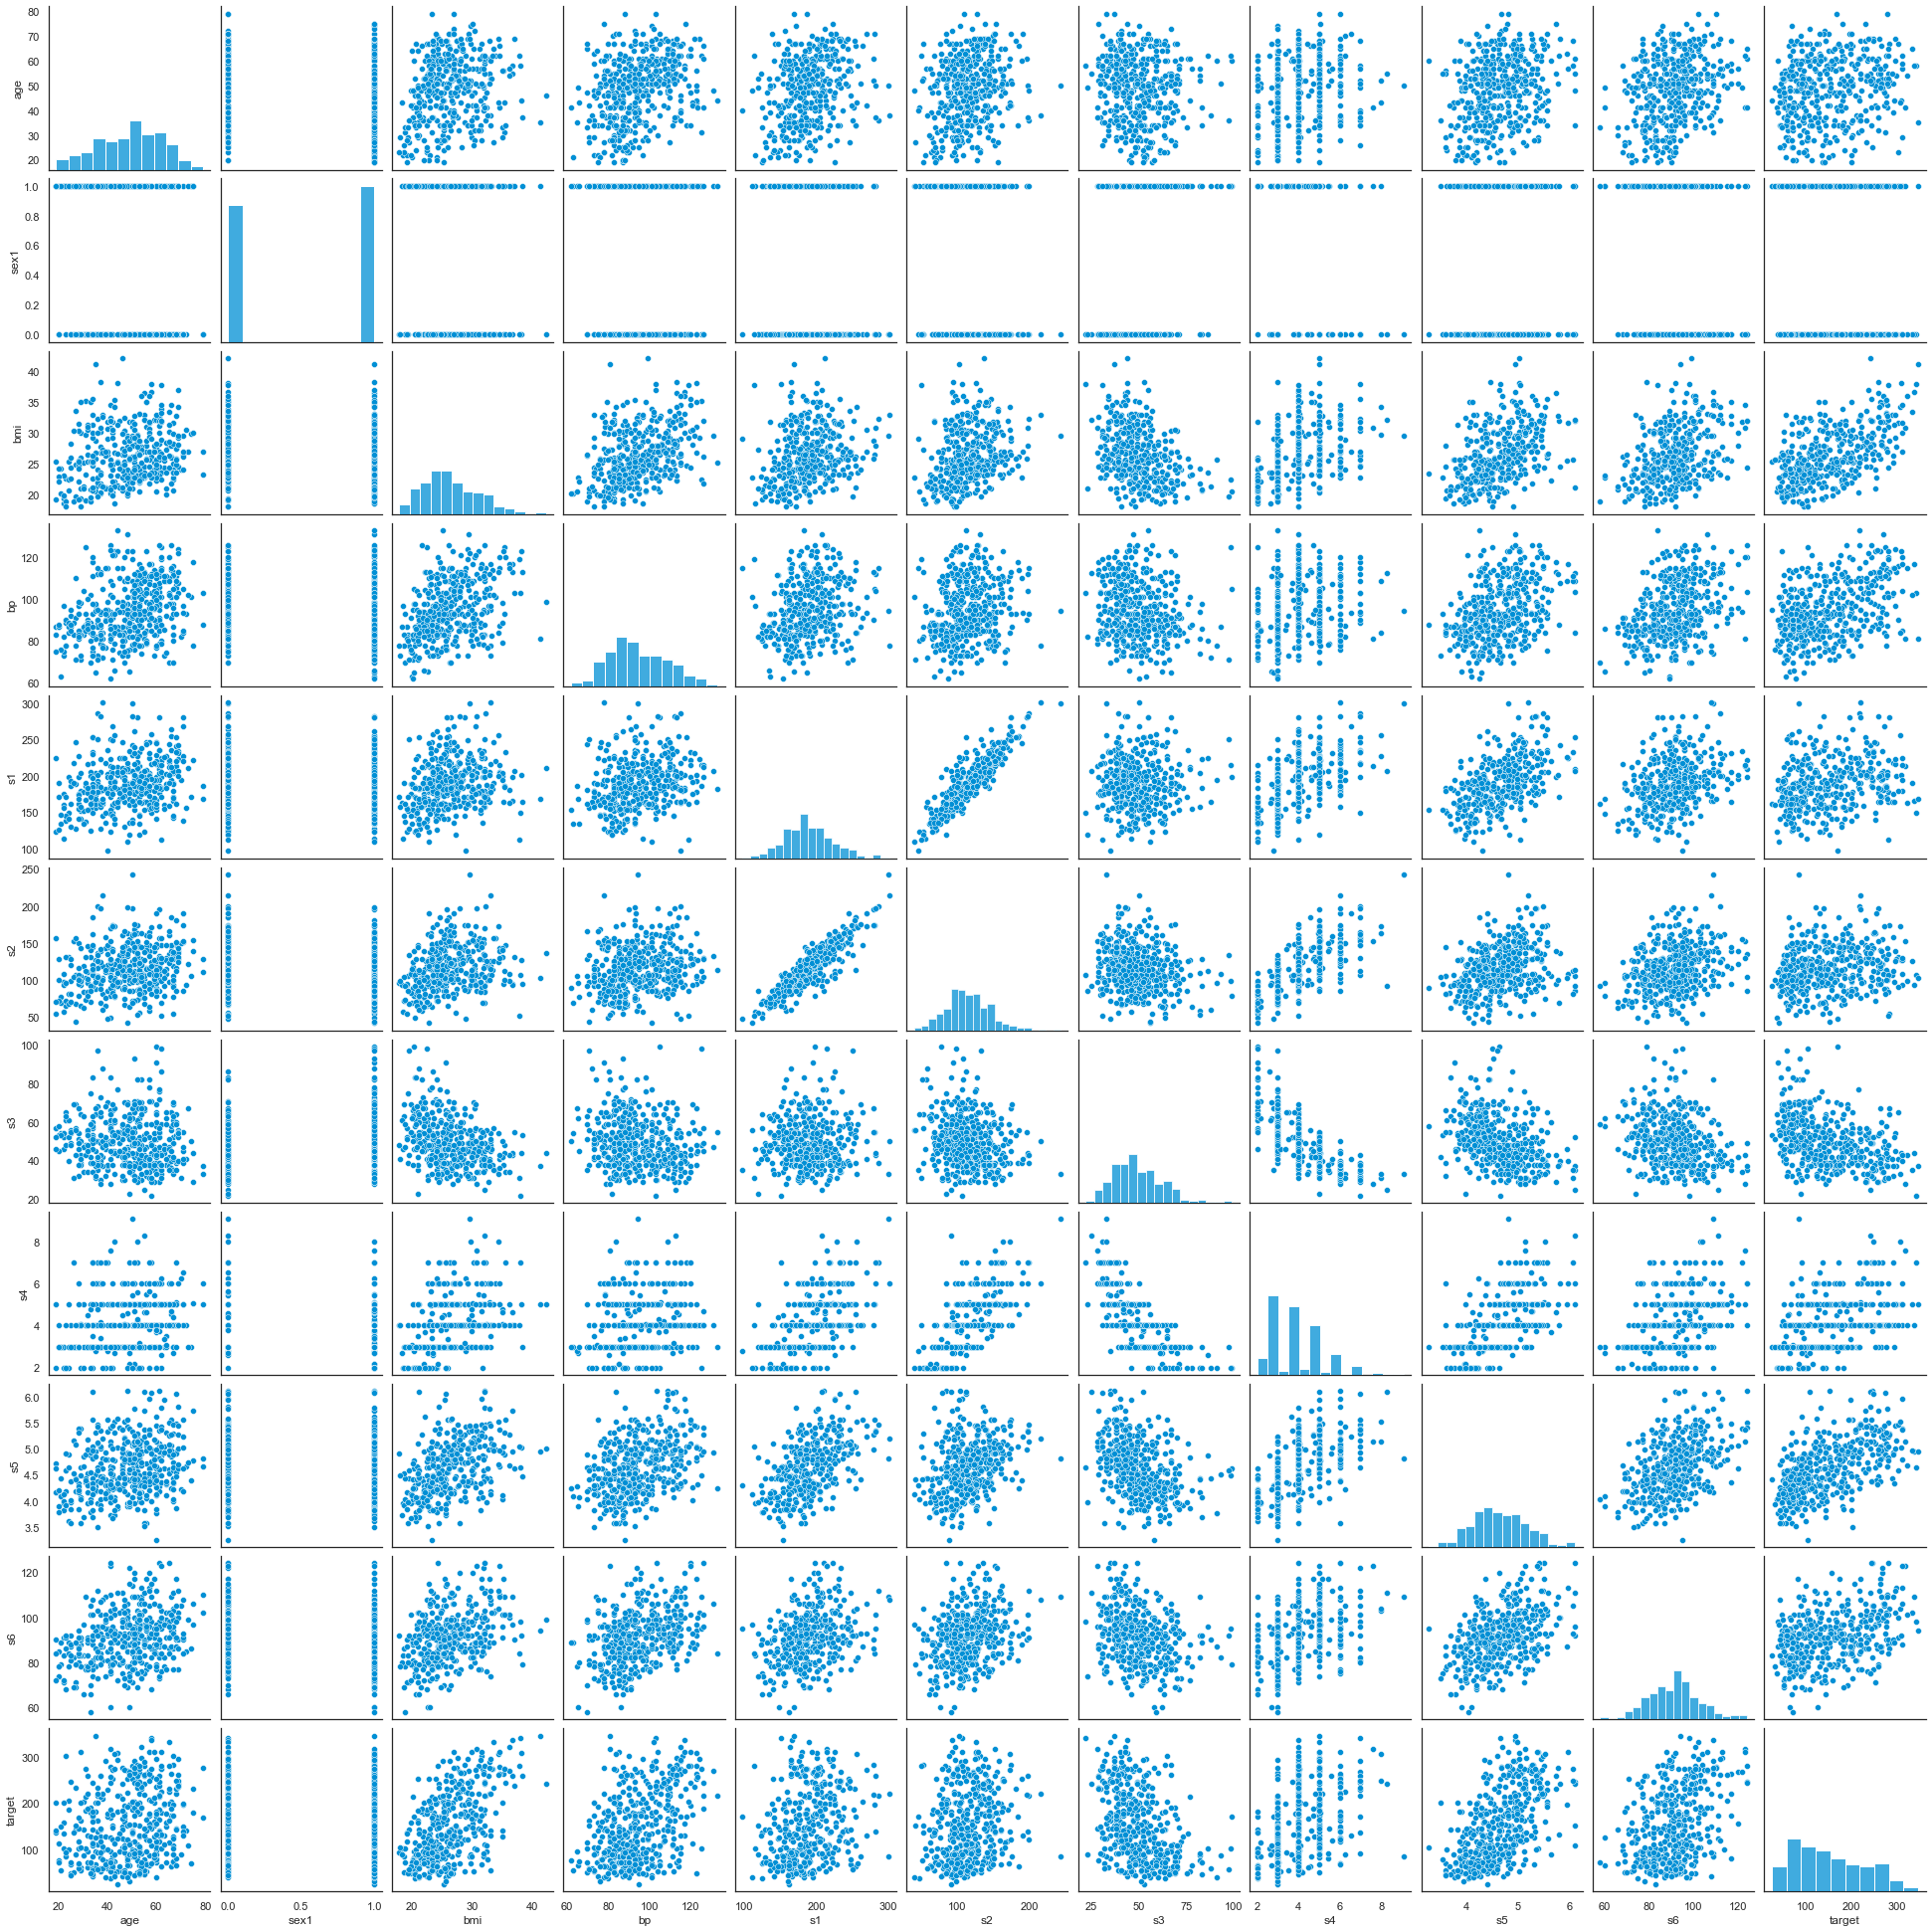

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



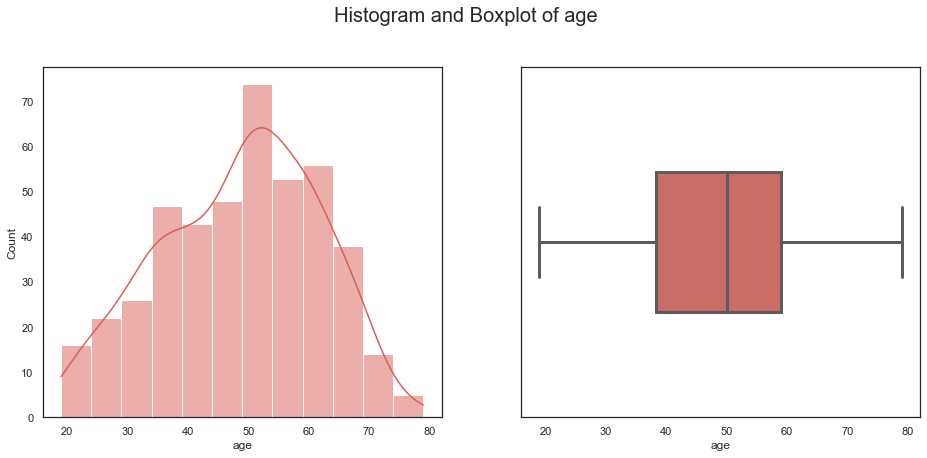

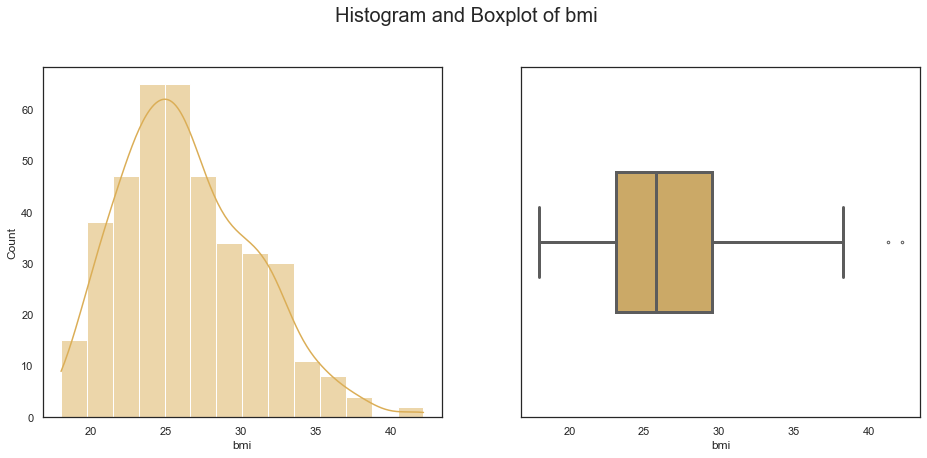

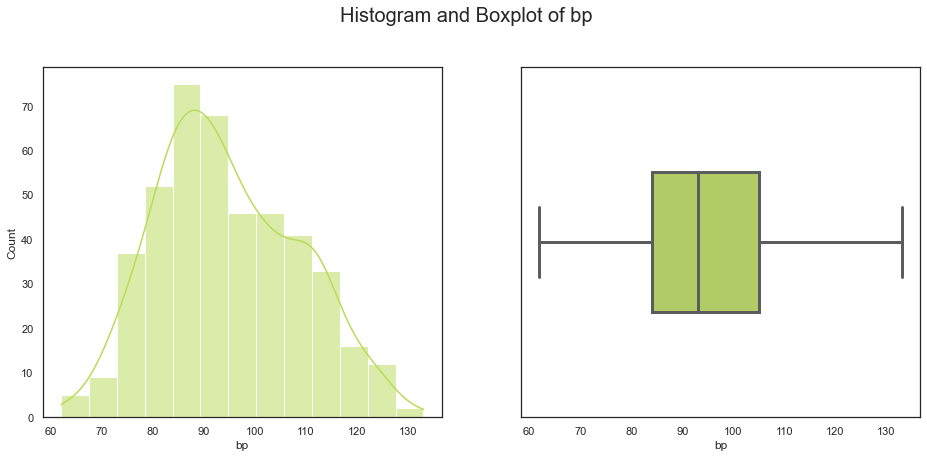

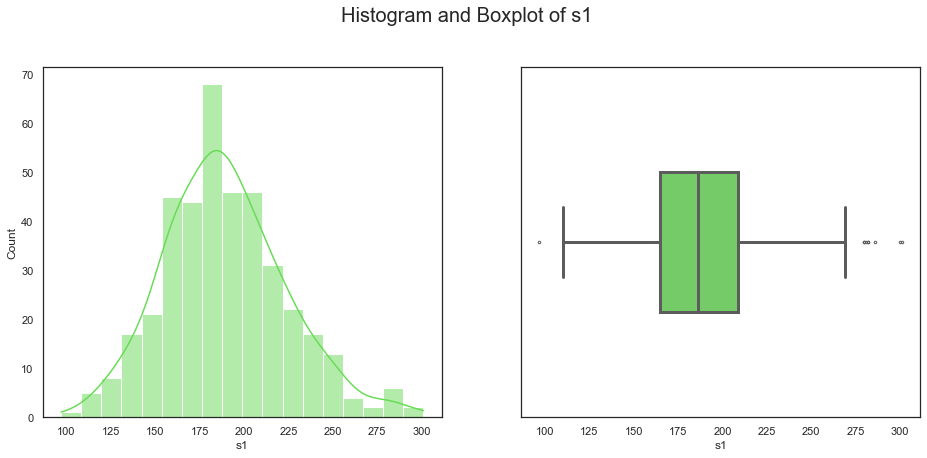

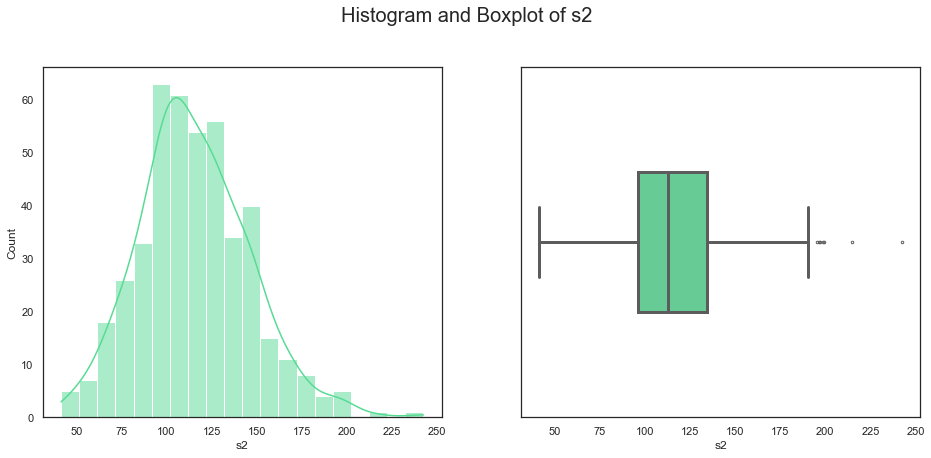

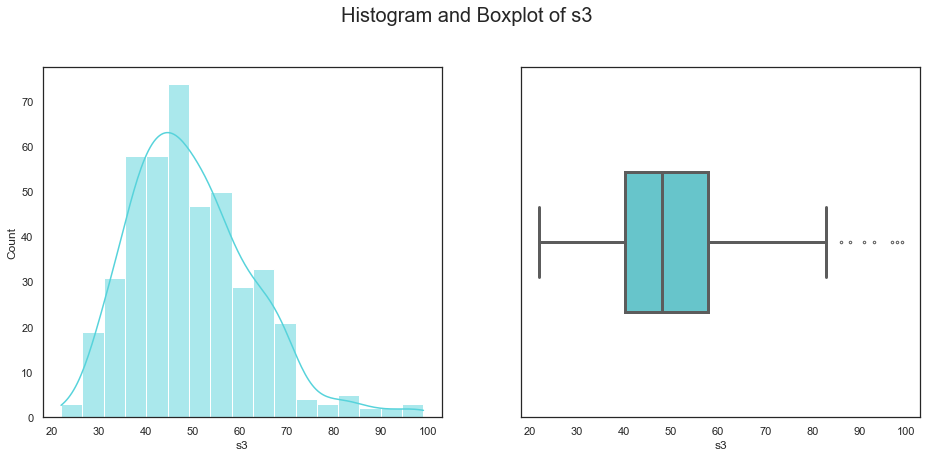

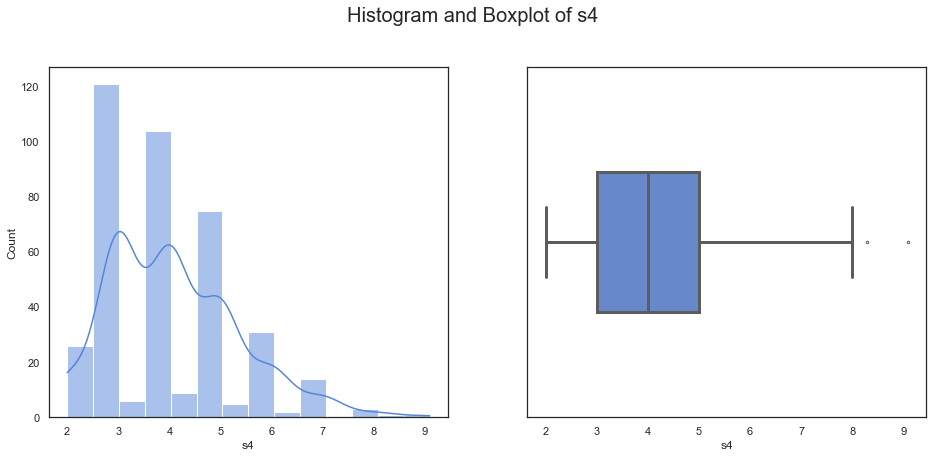

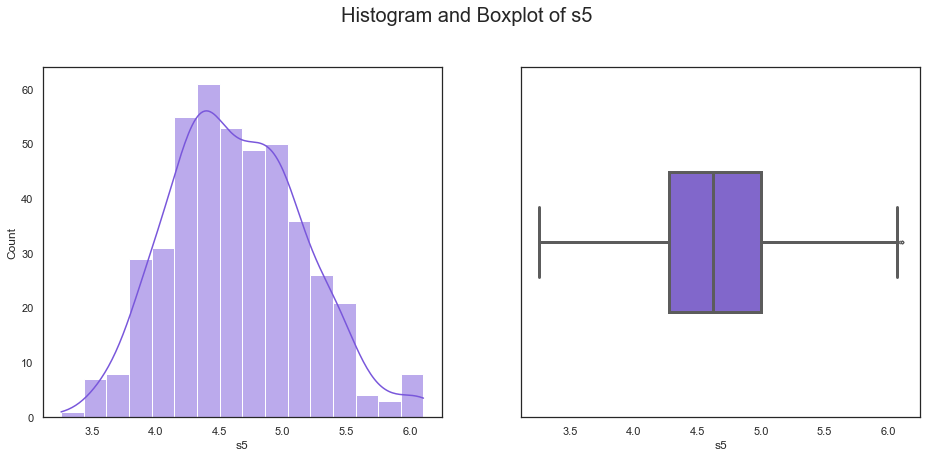

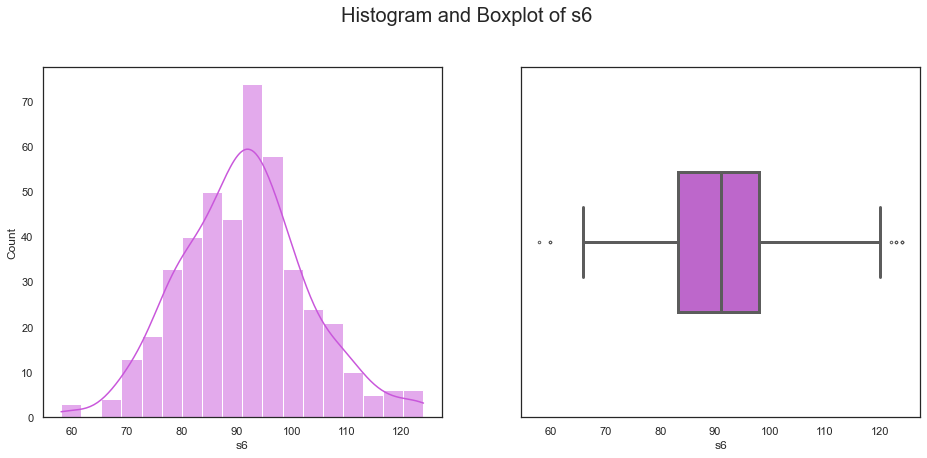

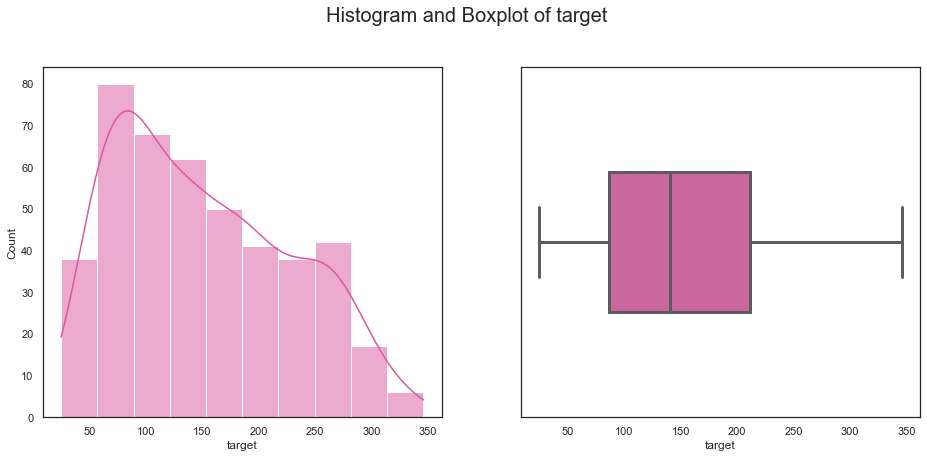

----------------------------------------------------------------------------------------------------
Countplot(s):



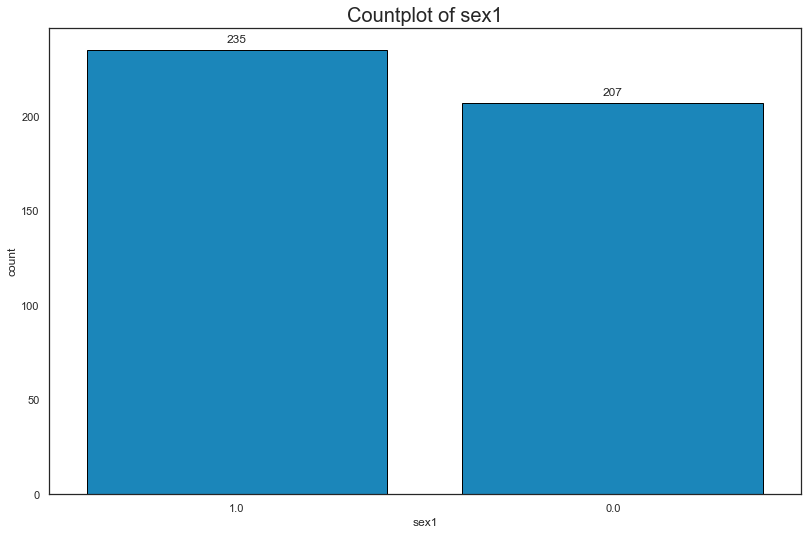

In [32]:
# This code may take a minute or two to finish running
fast_eda(diabetes)

<hr style="border:2px solid gray">


# Classification



## Import the iris data set



In [33]:
# Load the data set from sklearn
iris_sklearn = load_iris()

# Extract the data and target labels as a numpy array
iris_npy = np.concatenate([iris_sklearn['data'], np.atleast_2d(iris_sklearn['target']).T], axis=1)

# Define column names
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']

# Convert the numpy array to a pandas dataframe with column names
iris = pd.DataFrame(iris_npy, columns=col_names)

# Print a description of the dataset
print(iris_sklearn['DESCR'])
print(iris_sklearn)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [34]:
iris['target'].sample(5)

118    2.0
54     1.0
142    2.0
35     0.0
73     1.0
Name: target, dtype: float64

In [35]:
class_names = dict(zip(list(map(float, range(len(iris_sklearn['target_names'])))), iris_sklearn['target_names']))
print(class_names)
print(list(map(float, range(len(iris_sklearn['target_names'])))))

{0.0: 'setosa', 1.0: 'versicolor', 2.0: 'virginica'}
[0.0, 1.0, 2.0]


## Perform EDA on the iris data set



DataFrame Head:


sepal_length  sepal_width  petal_length  petal_width  target
0           5.1          3.5           1.4          0.2     0.0
1           4.9          3.0           1.4          0.2     0.0
2           4.7          3.2           1.3          0.2     0.0

DataFrame Tail:


sepal_length  sepal_width  petal_length  petal_width  target
147           6.5          3.0           5.2          2.0     2.0
148           6.2          3.4           5.4          2.3     2.0
149           5.9          3.0           5.1          1.8     2.0

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(150, 5)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



----------------------------------------------------------------------------------------------------
DataFrame Correlation:



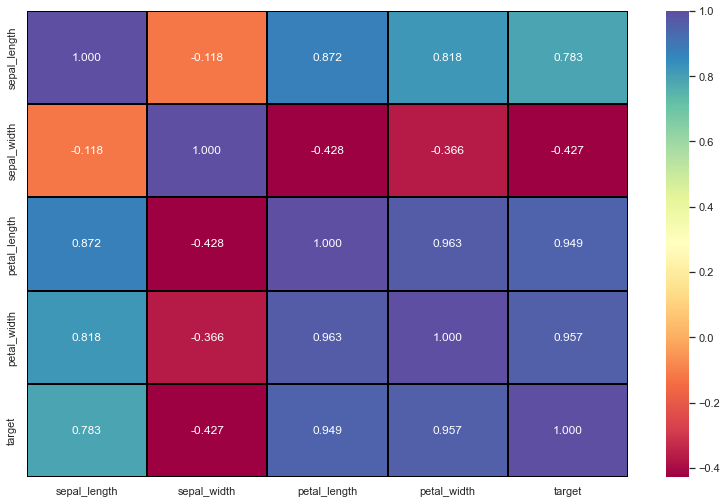

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



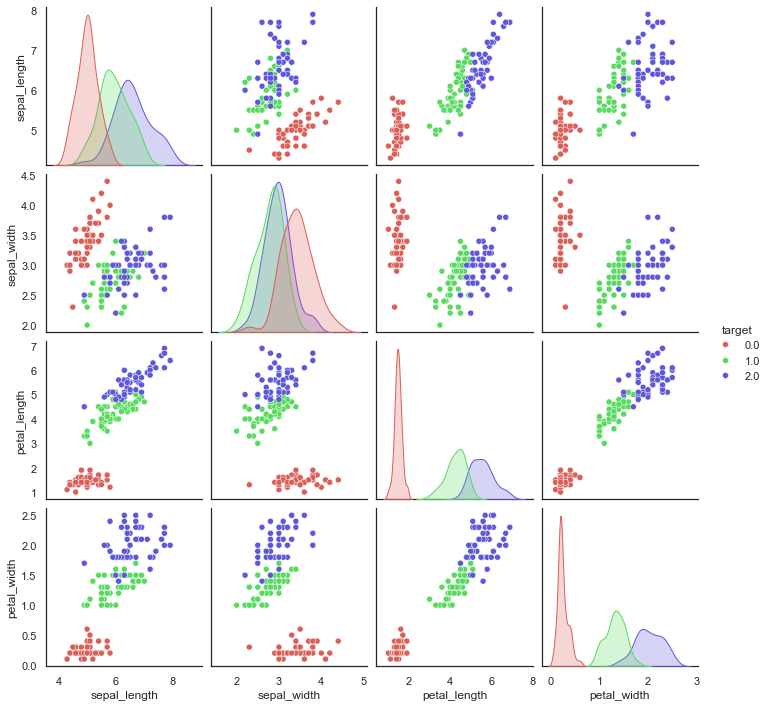

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



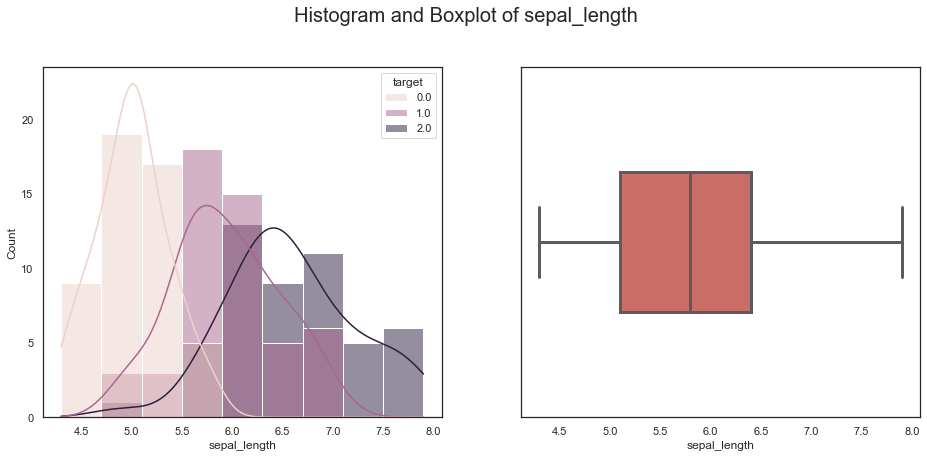

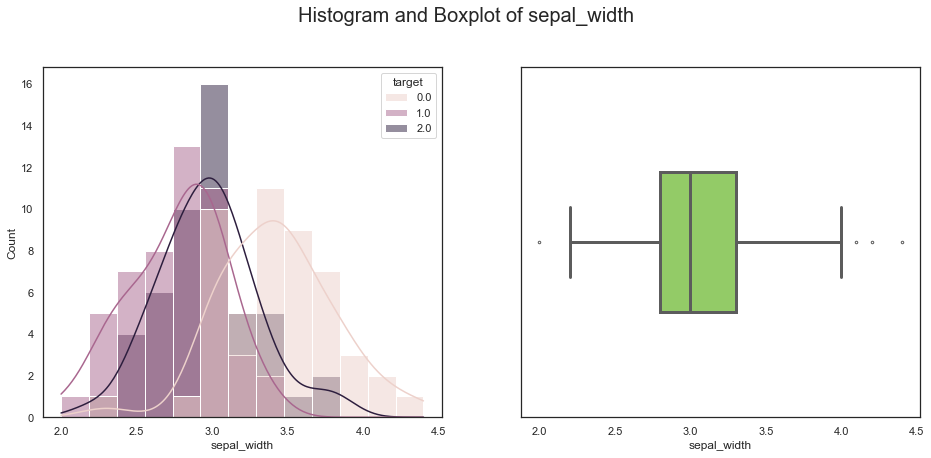

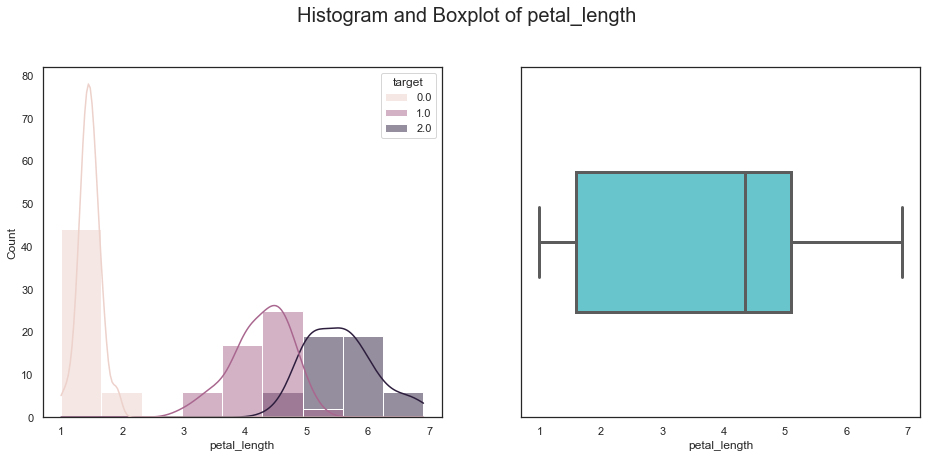

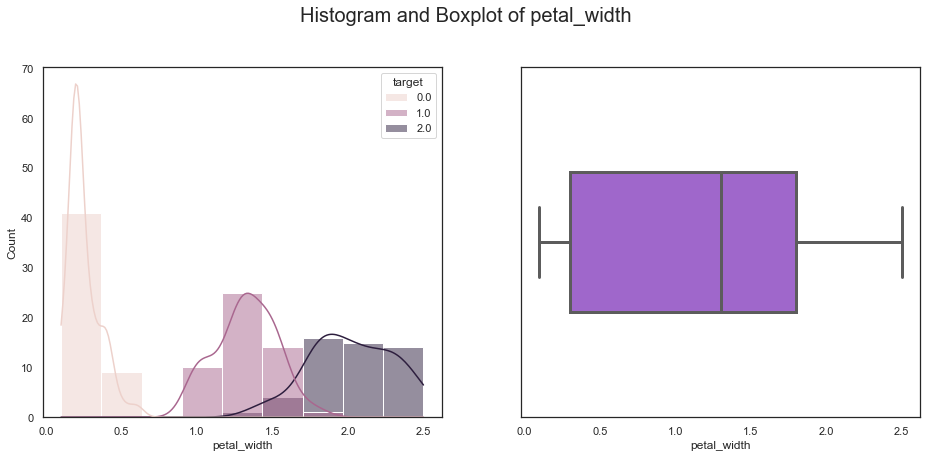

----------------------------------------------------------------------------------------------------
Countplot(s):



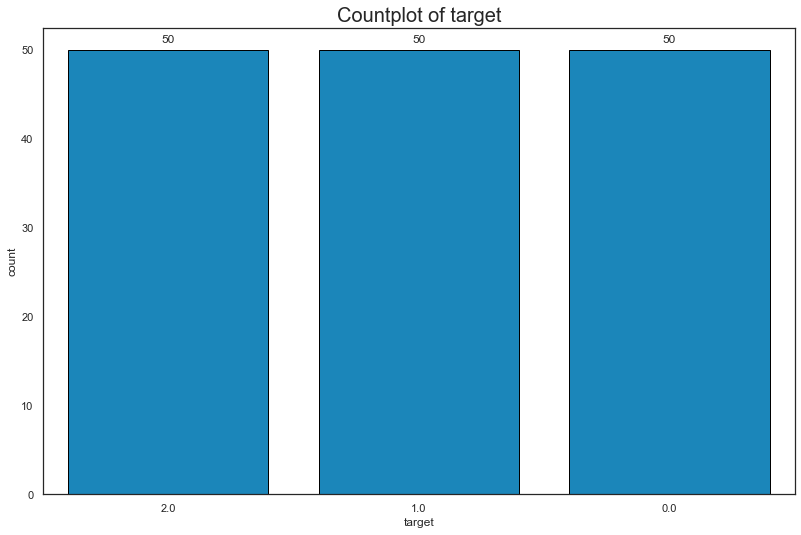

In [36]:
### TYPE YOUR SOLUTION HERE:
fast_eda(iris,target='target')

---


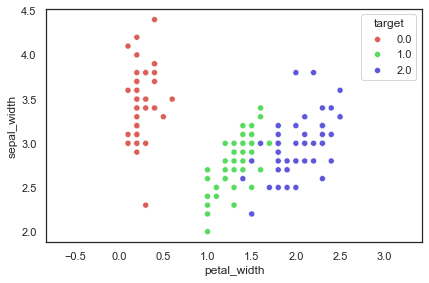

In [37]:
plt.axis('equal')
sns.scatterplot(iris, x='petal_width', y='sepal_width', hue='target', palette=sns.color_palette("hls", iris['target'].nunique()))
plt.show()

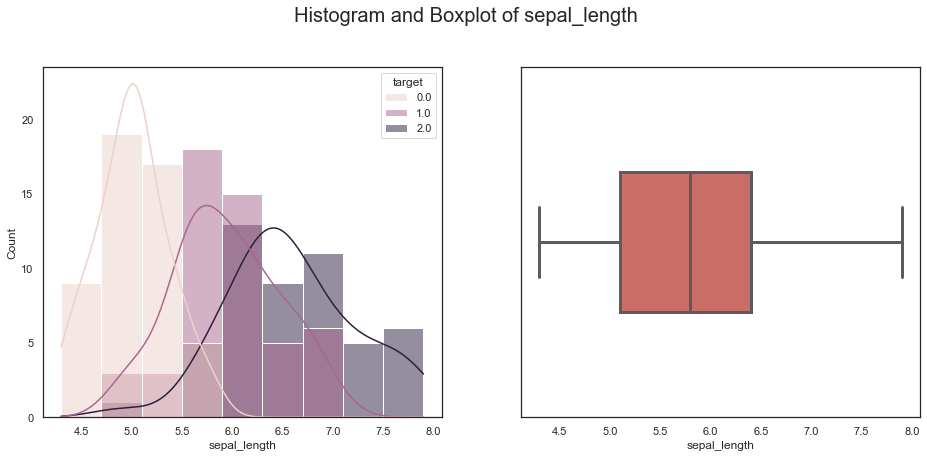

In [38]:
for idx, col in enumerate(['sepal_length']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(iris, x = iris[col], kde = True,
                 color = sns.color_palette("hls", iris['target'].nunique()), ax = ax1, hue = 'target')
    sns.boxplot(x = iris[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", iris['target'].nunique())[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

---


---


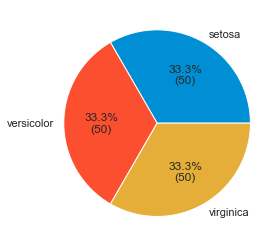

In [39]:

# Define a function to format value counts into percentages
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

# Get value counts
vc = iris['target'].value_counts()

# Draw a pie chart using value counts and the `autopct_format` format
_ = plt.pie(vc, labels = vc.rename(class_names).index, autopct=autopct_format(vc))

There are 50 observations for each of the 3 classes, indicating that this data set is balanced.
